# Aim:
Now that we have our initial prep done and have an initial understanding of the data, prepare the data for use by various algorithms.

There is data available to use over a period of 3 and a bit years. Also there are a range of features available for people to use.

The output of this notebook is csv files of the complete data sets that can then be read in by other analysis scripts that will filter down to the required data frame and the required feature set.

Currently there are 3 different sets of data:
1. Data on each bike station (at a bike station level)
2. Bike transaction data (5 min intervals)
3. Weather data (hourly)

In [2]:
import pandas as pd
import datetime as dt
import numpy as np

## Read in historical data
Downloaded from https://data.smartdublin.ie/dataset/dublinbikes-api

In [3]:
data_files = [
    "dublinbikes_20190401_20190701.csv",  # Apr - Jun 2019
    "dublinbikes_20190701_20191001.csv",  # Jul - Sep 2019
    "dublinbikes_20191001_20200101.csv",  # Oct - Dec 2019
    "dublinbikes_20200101_20200401.csv",  # Jan - Mar 2020
    "dublinbikes_20200401_20200701.csv",  # Apr - Jun 2020
    "dublinbikes_20201001_20210101.csv",  # Oct - Dec 2020
    "dublinbikes_20210101_20210401.csv",  # Jan - Mar 2021
    "dublinbikes_20210401_20210701.csv",  # Apr - Jun 2021
    "dublinbikes_20210701_20211001.csv",  # Jul - Oct 2021
    "dublinbikes_20211001_20220101.csv",  # Oct - Dec 2021
]

In [4]:
station_level_data = ['STATION ID', 'TIME', 'LAST UPDATED', 'BIKE STANDS', 'AVAILABLE BIKE STANDS', 
                      'AVAILABLE BIKES', 'STATUS']

In [5]:
df_data = []

for each in data_files:
    df_data.append(pd.read_csv("data/" + str(each))[station_level_data])
    
df = pd.concat(df_data)

In [6]:
df.head()

,STATION ID,TIME,LAST UPDATED,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS
0,2,2019-04-01 00:00:06,2019-03-31 23:52:05,20,14,6,Open
1,2,2019-04-01 00:05:04,2019-04-01 00:02:13,20,14,6,Open
2,2,2019-04-01 00:10:04,2019-04-01 00:02:13,20,14,6,Open
3,2,2019-04-01 00:15:03,2019-04-01 00:12:21,20,14,6,Open
4,2,2019-04-01 00:20:03,2019-04-01 00:12:21,20,14,6,Open


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27192762 entries, 0 to 2776084
Data columns (total 7 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   STATION ID             int64 
 1   TIME                   object
 2   LAST UPDATED           object
 3   BIKE STANDS            int64 
 4   AVAILABLE BIKE STANDS  int64 
 5   AVAILABLE BIKES        int64 
 6   STATUS                 object
dtypes: int64(4), object(3)
memory usage: 1.6+ GB


### Adapting code from Rachael Breslin's blog post

In [8]:
df[df.STATUS != 'Open'][['STATION ID']].drop_duplicates()

,STATION ID
920514,35
943220,114
1867181,46
1991340,25
1991628,26
...,...
342548,108
373359,106
376307,116
376526,117


90 stations were closed at some stage during the time line of interest. Dropping stations from the transactional data when they have a status of 'Close' will cause gaps in the timeline for some stations -> something to bear in mind when modelling.

In [9]:
# Drop data from closed stations
df = df[df['STATUS'] == 'Open']

The blog uses the 'LAST UPDATED' for the date-time column, i.e. when a data entry was last updated. 
However, the 'TIME' column is more accurate as corresponds to the actual 5 min intervals of recording.Therefore, use 'TIME' going forward


## Deconstruct the timestamps into various components

In [10]:
# First convert to a datetime object 
df['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in df["TIME"]]


In [11]:
# Deconstruct the timestamp further
df['DATE'] = df.DATETIME.dt.date
df['YEAR'] = df.DATETIME.dt.year
df['MONTH'] = df.DATETIME.dt.month

# Get the day of the week as a number. 0 = Sunday, Saturday = 6.
df['DAY_NUMBER'] = df.DATETIME.dt.dayofweek
df['HOUR'] = df.DATETIME.dt.hour
df['MINUTE'] = df.DATETIME.dt.minute

### Create important features
The intial analysis by Rachael Breslin calculated 'OCCUPANCY_PCT' as 'AVAILABLE BIKES' / 'BIKE STANDS'. 
However from the initial exploration, there are situations where 
BIKE STANDS' != 'AVAILABLE BIKES' + 'AVAILABLE BIKE STANDS',

In [15]:
# Situations where the stated level of bike stands is greater than the sum of available bike stands and 
# available bikes
tmp = df[df['BIKE STANDS'] > df['AVAILABLE BIKES'] + df['AVAILABLE BIKE STANDS']]\
    [['BIKE STANDS', 'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES']]
print("Number of occurrences where the stated level of bike stands is greater than the sum of available bike stands and available bikes:", len(tmp))
tmp.head()


Number of occurrences where the stated level of bike stands is greater than the sum of available bike stands and available bikes: 1236304


,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES
382,20,19,0
658,20,19,0
673,20,19,0
674,20,19,0
1050,40,27,12


In [16]:
# Situations where the stated level of bike stands is less than the sum of available bike stands and 
# available bikes
tmp = df[df['BIKE STANDS'] < df['AVAILABLE BIKES'] + df['AVAILABLE BIKE STANDS']]\
    [['BIKE STANDS', 'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES']]
print("Number of occurrences where the stated level of bike stands is less than the sum of available bike stands and  available bikes:", len(tmp))
tmp.head()

Number of occurrences where the stated level of bike stands is less than the sum of available bike stands and  available bikes: 10091


,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES
35407,20,22,0
35408,20,22,0
35409,20,22,0
101795,20,20,1
101796,20,20,1


From above, assume that bike stands is not always an accurate representation of the actual station capacity at
a given time. Use 'AVAILABLE BIKES' + 'AVAILABLE BIKE STANDS' as a measure of capacity instead

In [19]:
df['OCCUPANCY_PCT'] =  df['AVAILABLE BIKES'] / (df['AVAILABLE BIKES'] + df['AVAILABLE BIKE STANDS'])
df['FULL'] = np.where(df['OCCUPANCY_PCT'] == 0, 1, 0 )
df['EMPTY'] = np.where(df['OCCUPANCY_PCT'] == 1, 1, 0 )


In [20]:
# Sanity check
df[['OCCUPANCY_PCT']].describe()

,OCCUPANCY_PCT
count,2.708920e+07
mean,3.689747e-01
std,2.819564e-01
min,0.000000e+00
25%,1.333333e-01
50%,3.250000e-01
75%,5.500000e-01
max,1.000000e+00


In [21]:
df.head()

,STATION ID,TIME,LAST UPDATED,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,DATETIME,DATE,YEAR,MONTH,DAY_NUMBER,HOUR,MINUTE,OCCUPANCY_PCT,FULL,EMPTY
0,2,2019-04-01 00:00:06,2019-03-31 23:52:05,20,14,6,Open,2019-04-01 00:00:06,2019-04-01,2019,4,0,0,0,0.3,0,0
1,2,2019-04-01 00:05:04,2019-04-01 00:02:13,20,14,6,Open,2019-04-01 00:05:04,2019-04-01,2019,4,0,0,5,0.3,0,0
2,2,2019-04-01 00:10:04,2019-04-01 00:02:13,20,14,6,Open,2019-04-01 00:10:04,2019-04-01,2019,4,0,0,10,0.3,0,0
3,2,2019-04-01 00:15:03,2019-04-01 00:12:21,20,14,6,Open,2019-04-01 00:15:03,2019-04-01,2019,4,0,0,15,0.3,0,0
4,2,2019-04-01 00:20:03,2019-04-01 00:12:21,20,14,6,Open,2019-04-01 00:20:03,2019-04-01,2019,4,0,0,20,0.3,0,0


Next get an estimate of the total movement of bikes in and out of the station from one interval to the next. 
We do this by first sorting the data by station id and datetime. We then calculate the difference in available
bike stands between the current interval and the previous interval. 

In [22]:
bike_flow = df[['STATION ID', 'DATETIME', 'AVAILABLE BIKE STANDS']].copy().sort_values(by=['STATION ID', 'DATETIME'])
bike_flow['BIKE_ARR_DEP'] = bike_flow['AVAILABLE BIKE STANDS'].diff(-1)

Sanity check next....

In [23]:
bike_flow[(bike_flow.BIKE_ARR_DEP > 0) & (bike_flow['STATION ID']==36)][['STATION ID', 'DATETIME', 
                                                          'AVAILABLE BIKE STANDS', 'BIKE_ARR_DEP', 
                                                         ]].head(n=50)

,STATION ID,DATETIME,AVAILABLE BIKE STANDS,BIKE_ARR_DEP
9528,36,2019-04-01 04:45:02,36,1.0
9530,36,2019-04-01 04:55:03,35,1.0
9538,36,2019-04-01 05:35:04,34,1.0
9540,36,2019-04-01 05:45:02,33,1.0
9541,36,2019-04-01 05:50:03,32,1.0
9544,36,2019-04-01 06:05:03,31,1.0
9550,36,2019-04-01 06:35:03,30,2.0
9552,36,2019-04-01 06:45:03,28,1.0
9556,36,2019-04-01 07:05:03,27,2.0
9558,36,2019-04-01 07:15:03,25,3.0


In [24]:
bike_flow[(bike_flow.BIKE_ARR_DEP < 0) & (bike_flow['STATION ID']==36)][['STATION ID', 'DATETIME', 
                                                          'AVAILABLE BIKE STANDS', 
                                                          'BIKE_ARR_DEP', 
                                                         ]].head(n=50)

,STATION ID,DATETIME,AVAILABLE BIKE STANDS,BIKE_ARR_DEP
9523,36,2019-04-01 04:20:02,35,-1.0
9571,36,2019-04-01 08:20:02,0,-1.0
9575,36,2019-04-01 08:40:05,0,-1.0
9587,36,2019-04-01 09:40:04,0,-1.0
9589,36,2019-04-01 09:50:04,1,-1.0
9602,36,2019-04-01 10:55:04,2,-1.0
9603,36,2019-04-01 11:00:04,3,-1.0
9605,36,2019-04-01 11:10:03,4,-1.0
9613,36,2019-04-01 11:50:03,2,-8.0
9615,36,2019-04-01 12:00:06,10,-1.0


In [25]:
bike_flow.columns

Index(['STATION ID', 'DATETIME', 'AVAILABLE BIKE STANDS', 'BIKE_ARR_DEP'], dtype='object')

In [26]:
df = df.merge(bike_flow[['STATION ID', 'DATETIME', 'BIKE_ARR_DEP']], 
              on=['DATETIME', 'STATION ID'], how='left')

In [27]:
df.columns

Index(['STATION ID', 'TIME', 'LAST UPDATED', 'BIKE STANDS',
       'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES', 'STATUS', 'DATETIME',
       'DATE', 'YEAR', 'MONTH', 'DAY_NUMBER', 'HOUR', 'MINUTE',
       'OCCUPANCY_PCT', 'FULL', 'EMPTY', 'BIKE_ARR_DEP'],
      dtype='object')

### Identify situations where bike stations are rebalanced i.e. bikes are re-distributed where needed
What is the typical distribution of bike transactions within each interval? What values do we have at the extremes of the distrbution?

In [28]:
df['BIKE_ARR_DEP_ABS'] = abs(df['BIKE_ARR_DEP'])  

<AxesSubplot:>

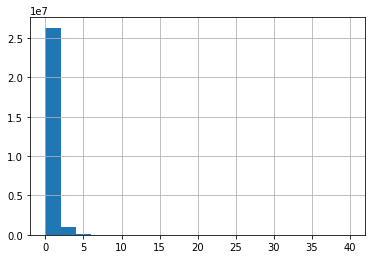

In [29]:
df.BIKE_ARR_DEP_ABS.hist(bins=20)

In [30]:
df.BIKE_ARR_DEP_ABS.describe()

count    2.750901e+07
mean     2.644165e-01
std      7.672442e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+01
Name: BIKE_ARR_DEP_ABS, dtype: float64

In [31]:
df.BIKE_ARR_DEP_ABS.quantile([0.5, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 1.0])

0.500     0.0
0.900     1.0
0.950     1.0
0.970     2.0
0.980     2.0
0.990     3.0
0.999     9.0
1.000    40.0
Name: BIKE_ARR_DEP_ABS, dtype: float64

In [32]:
df.BIKE_ARR_DEP_ABS.value_counts()

0.0     22434635
1.0      3876106
2.0       803952
3.0       207633
4.0        73174
5.0        32572
6.0        22610
7.0        12953
8.0        12488
9.0         9974
10.0        6717
11.0        3638
12.0        3489
13.0        1938
14.0        1761
15.0        1196
16.0        1196
17.0         988
18.0         907
19.0         271
20.0         184
21.0          86
22.0          65
23.0          51
25.0          44
26.0          44
30.0          43
24.0          43
28.0          37
29.0          31
40.0          31
27.0          25
34.0          19
38.0          19
33.0          16
39.0          15
32.0          15
36.0          15
31.0          14
35.0          11
37.0           8
Name: BIKE_ARR_DEP_ABS, dtype: int64

10 seems like a reasonable number. Are there any stations that have 10 or less bike stands?

In [33]:
df[['STATION ID', 'BIKE STANDS']].drop_duplicates().describe()

,STATION ID,BIKE STANDS
count,117.000000,117.000000
mean,64.076923,31.743590
std,53.228712,8.081646
min,2.000000,1.000000
25%,32.000000,29.000000
50%,61.000000,30.000000
75%,90.000000,40.000000
max,507.000000,40.000000


In [34]:
df[df['BIKE STANDS'] < 10]

,STATION ID,TIME,LAST UPDATED,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,DATETIME,DATE,YEAR,MONTH,DAY_NUMBER,HOUR,MINUTE,OCCUPANCY_PCT,FULL,EMPTY,BIKE_ARR_DEP,BIKE_ARR_DEP_ABS
17491942,507,2021-02-17 13:05:02,2021-02-17 12:57:55,1,0,1,Open,2021-02-17 13:05:02,2021-02-17,2021,2,2,13,5,1.0,0,1,0.0,0.0
17491943,507,2021-02-17 13:10:02,2021-02-17 13:08:01,1,0,1,Open,2021-02-17 13:10:02,2021-02-17,2021,2,2,13,10,1.0,0,1,0.0,0.0
17491944,507,2021-02-17 13:15:02,2021-02-17 13:08:01,1,0,1,Open,2021-02-17 13:15:02,2021-02-17,2021,2,2,13,15,1.0,0,1,0.0,0.0
17491945,507,2021-02-17 13:20:02,2021-02-17 13:18:07,1,0,1,Open,2021-02-17 13:20:02,2021-02-17,2021,2,2,13,20,1.0,0,1,0.0,0.0
17491946,507,2021-02-17 13:25:03,2021-02-17 13:18:07,1,0,1,Open,2021-02-17 13:25:03,2021-02-17,2021,2,2,13,25,1.0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27509010,507,2022-01-01 23:35:02,2021-11-18 07:11:16,1,0,1,Open,2022-01-01 23:35:02,2022-01-01,2022,1,5,23,35,1.0,0,1,0.0,0.0
27509011,507,2022-01-01 23:40:02,2021-11-18 07:11:16,1,0,1,Open,2022-01-01 23:40:02,2022-01-01,2022,1,5,23,40,1.0,0,1,0.0,0.0
27509012,507,2022-01-01 23:45:02,2021-11-18 07:11:16,1,0,1,Open,2022-01-01 23:45:02,2022-01-01,2022,1,5,23,45,1.0,0,1,0.0,0.0
27509013,507,2022-01-01 23:50:02,2021-11-18 07:11:16,1,0,1,Open,2022-01-01 23:50:02,2022-01-01,2022,1,5,23,50,1.0,0,1,0.0,0.0


Station 507 is a test station with 1 bike stand so we can ignore that.

Some stations only have 16 bike stands while others have close to 40. Perhaps a ratio of absolute bike transaction in a interval to the number of bike stands would be more applicable?

Could also possibly refine it further with an assumption like if a station has continuous occupancy of <= 10% or >= 90% for _n_ number of intervals in a row, and then sees a significant number of bike transactions for the next interval, then consider this rebalancing?

It is hard to accurately deduce actual rebalancing activities.

For the moment, we will stick with a threshold of 10

In [35]:
# Attempt to create a distinction between rental and rebalancing.
# Based on the stats from above, a threshold of 10 seems reasonable
df['ACTIVITY_TYPE'] = np.where(df['BIKE_ARR_DEP_ABS'] >= 10, "REBALANCING", "RENTAL")
df['IMBALANCED'] = np.where(df['OCCUPANCY_PCT'] < .1, 1, np.where(df['OCCUPANCY_PCT'] > .9, 1,0 ))

### Drop any date from the JCDeaux test station

In [36]:
len(df[df['STATION ID'] == 507])

13007

In [37]:
df = df[df['STATION ID'] != 507]

In [38]:
df.columns

Index(['STATION ID', 'TIME', 'LAST UPDATED', 'BIKE STANDS',
       'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES', 'STATUS', 'DATETIME',
       'DATE', 'YEAR', 'MONTH', 'DAY_NUMBER', 'HOUR', 'MINUTE',
       'OCCUPANCY_PCT', 'FULL', 'EMPTY', 'BIKE_ARR_DEP', 'BIKE_ARR_DEP_ABS',
       'ACTIVITY_TYPE', 'IMBALANCED'],
      dtype='object')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27496008 entries, 0 to 27508726
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   STATION ID             int64         
 1   TIME                   object        
 2   LAST UPDATED           object        
 3   BIKE STANDS            int64         
 4   AVAILABLE BIKE STANDS  int64         
 5   AVAILABLE BIKES        int64         
 6   STATUS                 object        
 7   DATETIME               datetime64[ns]
 8   DATE                   object        
 9   YEAR                   int64         
 10  MONTH                  int64         
 11  DAY_NUMBER             int64         
 12  HOUR                   int64         
 13  MINUTE                 int64         
 14  OCCUPANCY_PCT          float64       
 15  FULL                   int64         
 16  EMPTY                  int64         
 17  BIKE_ARR_DEP           float64       
 18  BIKE_ARR_DEP_ABS    

## Write out to file

In [40]:
#Dropping:
#'TIME': Now captured as a datetime object in 'DATETIME'
#'LAST UPDATED': Captures when the data was last updated, not the actual data intervals
#'BIKE STANDS': Already captured in the bike station level data
#'STATUS': Only open stations are considered here, so this column contains no additional information.
#'BIKE_ARR_DEP_ABS': Information already captured by 'BIKE_ARR_DEP',and no longer needed for the calcualtion of ACTIVITY_TYPE

columns_of_interest = ['STATION ID', 'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES', 'DATETIME', 
                       'DATE', 'YEAR', 'MONTH', 'DAY_NUMBER', 'HOUR', 'MINUTE', 'OCCUPANCY_PCT', 
                       'FULL', 'EMPTY', 'BIKE_ARR_DEP', 'ACTIVITY_TYPE', 'IMBALANCED']

final = df[columns_of_interest].copy()
final.to_csv("preprocessed_bike_data.csv", index=False)


# Create pre-processed station data

In [41]:
raw_station_df = pd.read_csv("data/raw_station_data.csv")
raw_station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION ID  110 non-null    int64  
 1   NAME        110 non-null    object 
 2   ADDRESS     110 non-null    object 
 3   LATITUDE    110 non-null    float64
 4   LONGITUDE   110 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.4+ KB


## Extract the bike stand info from the bike transaction data

In [42]:
bike_stand_info = df[['STATION ID', 'BIKE STANDS']].drop_duplicates()
bike_stand_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 22387754
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   STATION ID   116 non-null    int64
 1   BIKE STANDS  116 non-null    int64
dtypes: int64(2)
memory usage: 2.7 KB


In [43]:
bike_stand_info['STATION ID'].value_counts()

108    2
2      1
75     1
87     1
86     1
      ..
37     1
36     1
35     1
34     1
116    1
Name: STATION ID, Length: 115, dtype: int64

108 has two numbers for bike stands

In [44]:
bike_stand_info[bike_stand_info['STATION ID'] == 108]

,STATION ID,BIKE STANDS
30135,108,40
22387754,108,35


In [45]:
df[df['STATION ID'] == 108][['BIKE STANDS', 'DATETIME', 'YEAR']].groupby(['BIKE STANDS', 'YEAR']).count()

DATETIME
BIKE STANDS YEAR          
35          2021     46397
            2022       288
40          2019     70753
            2020     74418
            2021     59691

Not an ideal solution, but just keep the number of bike stands as 40 for station 108 as it covers most of the time intervals

In [46]:
# drop the row that we don't want using its index
bike_stand_info = bike_stand_info.drop(axis='index', index=22387754)
# Sanity check
bike_stand_info[bike_stand_info['STATION ID'] == 108]

,STATION ID,BIKE STANDS
30135,108,40


In [47]:
bike_stand_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 9000186
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   STATION ID   115 non-null    int64
 1   BIKE STANDS  115 non-null    int64
dtypes: int64(2)
memory usage: 2.7 KB


Now have bike stand information. Combine with bike station information

In [48]:
station_df = bike_stand_info.merge(raw_station_df, how='outer')
station_df.head()

,STATION ID,BIKE STANDS,NAME,ADDRESS,LATITUDE,LONGITUDE
0,2,20,BLESSINGTON STREET,Blessington Street,53.356769,-6.268140
1,3,20,BOLTON STREET,Bolton Street,53.351182,-6.269859
2,4,20,GREEK STREET,Greek Street,53.346874,-6.272976
3,5,40,CHARLEMONT PLACE,Charlemont Street,53.330662,-6.260177
4,6,20,CHRISTCHURCH PLACE,Christchurch Place,53.343368,-6.270120


In [49]:
station_df[station_df['STATION ID'].isnull()]

,STATION ID,BIKE STANDS,NAME,ADDRESS,LATITUDE,LONGITUDE


In [50]:
station_df[station_df.NAME.isnull()]

,STATION ID,BIKE STANDS,NAME,ADDRESS,LATITUDE,LONGITUDE
12,14,30,NaN,NaN,NaN,NaN
32,35,30,NaN,NaN,NaN,NaN
43,46,20,NaN,NaN,NaN,NaN
57,60,30,NaN,NaN,NaN,NaN
67,70,28,NaN,NaN,NaN,NaN


In [51]:
missing_stations = list(set(bike_stand_info['STATION ID']).difference(set(raw_station_df['STATION ID'])))
missing_stations

[35, 70, 46, 14, 60]

We have 4 station IDs that are present in the transactional bike data but are missing in the station level data

In [52]:
df[df['STATION ID'].isin(missing_stations)][['STATION ID', 'DATE']]

,STATION ID,DATE
3444,14,2019-04-01
3445,14,2019-04-01
3446,14,2019-04-01
3447,14,2019-04-01
3448,14,2019-04-01
...,...,...
27492882,60,2022-01-01
27492883,60,2022-01-01
27492884,60,2022-01-01
27492885,60,2022-01-01


In [53]:
station = 14
tmp = df[df['STATION ID'] == station][['STATION ID', 'DATE']]
tmp.DATE.max()

datetime.date(2019, 11, 2)

In [54]:
min_date = []
max_date = []

for station in missing_stations:
    tmp = df[df['STATION ID'] == station][['STATION ID', 'DATE']]
    min_date.append(tmp.DATE.min())
    max_date.append(tmp.DATE.max())
    
missing_station_dates = pd.DataFrame(data={'STATION': missing_stations,
                                          'MIN': min_date,
                                          'MAX': max_date})

missing_station_dates

,STATION,MIN,MAX
0,35,2019-04-01,2019-04-29
1,70,2019-04-01,2019-07-17
2,46,2019-04-01,2019-05-28
3,14,2019-04-01,2019-11-02
4,60,2019-04-01,2022-01-01


All of the above have max dates in the past, suggesting that these stations may no longer be in use. Station level information may only be provided for currently active stations.


### Write station level information out to file

In [55]:
station_df.to_csv("preprocessed_station_level_data.csv", index=False)

# Weather data

Rachael Breslin considered weather conditions such as rain fall and temperature in her modelling. Surprisingly these showed very little importance in the model to predict the occupancy rate of bike stations.

Wind related variables were not inclued in the original modelling. From personal experience of cycling around 
Dublin, I have found wind to be a personal influence on whether I would choose to cycle or not on a given day.
Therefore it would be interesting to enhance the existing weather data with wind related data for this analysis.

Historial weather data from various weather stations around the country is publically avaiable from 
https://www.met.ie/climate/available-data/historical-data .
There are 3 weather stations in Dublin with data at an hourly level - Casement, Dublin airport and the Phoenix Park
The Phoenix Park is located in the city centre near many of the bike stations, therefore it is the most relevant
source of local weather conditions for the bike stations. However, it lacks data on wind direction and speed.
Therefore, I took this from Dublin airport, and combined it with the Phoenix Park data in one csv merging on day and 
hourly intervals for the time period covered by the bike transaction data, to give an pre-processed weather file, enhanced with wind related data.

